In [1]:
%cd /mnt/hdd1/jkliu/Projects/ATGEmpirical/

/mnt/hdd1/jkliu/Projects/ATGEmpirical


/mnt/hdd1/jkliu/Projects/ATGEmpirical/venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from datetime import datetime


def extract_using_display(line, package_name):
    if "Displayed" not in line:
        return None, None
    current_activity = line.split("Displayed ")[-1].strip().split(": ")[0].replace("/", "")
    current_activity = transform_activtiy_name(current_activity, package_name)
    splits = line.split("Displayed ")[0].split(" ")
    time = f"2024-{splits[0]} {splits[1]}"
    time_stamp = datetime.fromisoformat(time)
    return current_activity, time_stamp


def extract_using_start(line, package_name):
    if " START " not in line:
        return
    if " cmp=" not in line:
        return
    current_activity = None
    splits = line.split(" ")
    time = f"2024-{splits[0]} {splits[1]}"
    time_stamp = datetime.fromisoformat(time)
    for s in splits:
        if "cmp" in s:
            s = s.replace("cmp=", "").replace("{", "").replace("}", "")
            current_activity = s.replace("/", "")
            current_activity = transform_activtiy_name(current_activity, package_name)
            break
    return current_activity, time_stamp

def extract_transitions_from_logcat(logcat_file: str, transitions: list, declared_activities: list, package_name: str):
    activity_time = {}
    transition_time = {}
    if not os.path.exists(logcat_file):
        print(f"Logcat file {logcat_file} does not exist")
        return
    last_activity = 'Start'
    first_time = None
    with open(logcat_file, "r") as logcatfile:
        lines = logcatfile.readlines()
        for line in lines:
            try:
                if "ActivityManager: " in line:
                    current_activity, time_stamp = extract_using_display(line, package_name)
                    # current_activity, time_stamp = extract_using_start(line, package_name)
                    # print(f"Current activity: {current_activity}")
                    if current_activity is None and time_stamp is None:
                        continue
                    if first_time is None:
                        first_time = time_stamp
                    time_interval = (time_stamp - first_time).total_seconds() / 60
                    is_valid_activity = False
                    for declared_activity in declared_activities:
                        if (declared_activity in current_activity) or (current_activity in declared_activity):
                            is_valid_activity = True
                            break
                    if not is_valid_activity:
                        continue
                    if current_activity not in activity_time:
                        activity_time[current_activity] = time_interval
                    if last_activity != 'Start':
                        for transition in transitions:
                            if transition in transition_time:
                                continue
                            src, tgt = transition.split(" -> ")
                            src, tgt = src.strip(), tgt.strip()
                            if ((src in last_activity) or (last_activity in src)) and (
                                    (tgt in current_activity) or (current_activity in tgt)):
                                transition_time[transition] = time_interval
                                # print(f"Time to get {transition} is {time_interval}")
                    # else:
                    #     transition_time['Start -> ' + current_activity] = time_interval
                    last_activity = current_activity
            except Exception as e:
                print(f"Error in line: {line}")
                print(f"Error: {e}")
                continue
    return activity_time, transition_time


In [3]:
from result_plot import common


def process_single_apk(apk_path: str, real_transition: list):
    apk_tool_activity_time = {}
    apk_others_transition_time = {}
    apk_real_transition_time = {}
    apk_transition_time = {}
    apk_tool_proportion = {}
    package_name, _, declared_activities, exported_activities = parse_manifest_file(apk_path)
    apk_path, tool_transitions = common.get_tool_result(apk_path, declared_activities)
    for tool in tools:
        try:
            _, _, logcat_file = get_path_of_result_file(tool, apk_path, "")
            if tool not in tool_transitions:
                continue
            tool_result = tool_transitions[tool]
            activity_time, raw_transition_time = extract_transitions_from_logcat(logcat_file, tool_result, declared_activities, package_name)
            gt_transition_time = {}
            for transition in real_transition:
                if transition in raw_transition_time:
                    gt_transition_time[transition] = raw_transition_time[transition]
            apk_tool_activity_time[tool] = set(activity_time.values())
            apk_others_transition_time[tool] = set(raw_transition_time.values()) - set(gt_transition_time.values())
            apk_real_transition_time[tool] = set(gt_transition_time.values())
            transition_time_list = []
            for transition in raw_transition_time.keys():
                transition_time_tuple = (transition, raw_transition_time[transition])
                transition_time_list.append(transition_time_tuple)
            apk_transition_time[tool] = transition_time_list
            if len(tool_result) == 0:
                apk_tool_proportion[tool] = 0
            else:
                print(f"Tool: {tool} {len(raw_transition_time)} {len(tool_result)} {len(raw_transition_time.keys()) / len(tool_result)}")
                apk_tool_proportion[tool] = len(raw_transition_time.keys()) / len(tool_result)
        except Exception as e:
            print(f"Error in {apk_path} {tool}")
            print(f"Error: {e}")
            continue
    return apk_tool_activity_time, apk_others_transition_time, apk_real_transition_time, apk_transition_time, apk_tool_proportion

Updated PATH: /usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/mnt/hdd1/jkliu/Applications/ncurses  # 你自己的 ncurses 目录/bin:/mnt/hdd1/jkliu/Applications/zsh/bin:/mnt/hdd1/jkliu/Applications/Android/cmdline-tools/latest/bin:/mnt/hdd1/jkliu/Applications/Android/emulator:/mnt/hdd1/jkliu/Applications/Android/platform-tools:/mnt/hdd1/jkliu/Applications/Android/tools:/mnt/hdd1/jkliu/Applications/Android/tools/bin:/mnt/hdd1/jkliu/Applications/Android/build-tools/35.0.0
/mnt/hdd1/jkliu/Applications/Android/build-tools/35.0.0/aapt
Successfully added aapt to PATH


In [4]:
from result_plot.common import *

real_transitions = get_real_transitions()
if "stoat" in real_transitions:
    real_transitions.pop("stoat")
set_current_version("first_round_no_internet")

In [5]:
apk_path = '/mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/com.gpl.rpg.AndorsTrail_75.apk'
real_transition = real_transitions[apk_path]
apk_tool_activity_time, apk_others_transition_time, apk_real_transition_time, apk_transition_time, apk_tool_proportion = process_single_apk(apk_path, real_transition)
print(apk_transition_time)

extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/com.gpl.rpg.AndorsTrail_75.apk
result_dir: /mnt/hdd1/jkliu/Projects/ATGEmpirical/results/first_round_no_internet/ape/com.gpl.rpg.AndorsTrail_75.apk
Tool: ape 20 26 0.7692307692307693
result_dir: /mnt/hdd1/jkliu/Projects/ATGEmpirical/results/first_round_no_internet/fastbot/com.gpl.rpg.AndorsTrail_75.apk
Tool: fastbot 14 18 0.7777777777777778
result_dir: /mnt/hdd1/jkliu/Projects/ATGEmpirical/results/first_round_no_internet/humanoid/com.gpl.rpg.AndorsTrail_75.apk
Tool: humanoid 3 5 0.6
result_dir: /mnt/hdd1/jkliu/Projects/ATGEmpirical/results/first_round_no_internet/monkey/com.gpl.rpg.AndorsTrail_75.apk
Tool: monkey 6 6 1.0
result_dir: /mnt/hdd1/jkliu/Projects/ATGEmpirical/results/first_round_no_internet/qtest/com.gpl.rpg.AndorsTrail_75.apk
result_dir: /mnt/hdd1/jkliu/Projects/ATGEmpirical/results/first_round_no_internet/scenedroid/com.gpl.rpg.AndorsTrail_75.apk
result_dir: /mnt/hdd1/jkliu/Projects/ATGEmpirical/res

In [6]:
import concurrent.futures


def process_all_apks(real_transitions: dict):
    futures = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
        tool_activity_time = {}
        others_transition_time = {}
        real_transition_time = {}
        raw_transition_time = {}
        all_tool_proportion = {}
        for tool in tools:
            if tool == "stoat":
                continue
            tool_activity_time[tool] = []
            others_transition_time[tool] = []
            real_transition_time[tool] = []
            raw_transition_time[tool] = []
            all_tool_proportion[tool] = []
        for apk_path in real_transitions.keys():
            futures.append(executor.submit(process_single_apk, apk_path, real_transitions[apk_path]))
        for future in concurrent.futures.as_completed(futures):
            apk_tool_activity_time, apk_others_transition_time, apk_real_transition_time, apk_transition_time, apk_tool_proportion = future.result()
            for tool in tools:
                if tool == "stoat":
                    continue
                if tool not in apk_tool_activity_time:
                    continue
                tool_activity_time[tool] += apk_tool_activity_time[tool]
                others_transition_time[tool] += apk_others_transition_time[tool]
                real_transition_time[tool] += apk_real_transition_time[tool]
                raw_transition_time[tool] += apk_transition_time[tool]
                all_tool_proportion[tool].append(apk_tool_proportion[tool])
    return tool_activity_time, others_transition_time, real_transition_time, raw_transition_time, all_tool_proportion


In [ ]:
tool_activity_time, others_transition_time, real_transition_time, raw_transition_time, all_tool_proportion = process_all_apks(real_transitions)

extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/com.gpl.rpg.AndorsTrail_75.apk
extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/com.darkempire78.opencalculator_42.apk
extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/rocks.poopjournal.vacationdays_9.apk
extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/org.documentfoundation.libreoffice_38.apk
extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/org.xphnx.ameixamonochrome_4100.apk
extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/de.k3b.android.toGoZip_30.apk
extracting summaries for /mnt/hdd1/jkliu/Projects/ATGEmpirical/apks/fdroid/com.github.axet.audiorecorder_377.apk
result_dir: /mnt/hdd1/jkliu/Projects/ATGEmpirical/results/first_round_no_internet/ape/com.gpl.rpg.AndorsTrail_75.apk
result_dir: /mnt/hdd1/jkliu/Projects/ATGEmpirical/results/first_round_no_internet/ape/org.documentfoundat

In [8]:
import matplotlib.pyplot as plt


def violin_plot(result_dict: dict, file_name: str = None, log_scale: bool = True, show_prop: bool = False):
    print("Plotting violin plot")
    plt.rcParams["font.size"] = 12
    plt.rcParams["font.family"] = "sans-serif"
    plt.figure(figsize=(8, 10))
    tools = list(result_dict.keys())
    values = list(result_dict.values())
    plt.figure()
    # plt.violinplot(values, showmedians=True, showextrema=False)
    plt.violinplot(values, showmeans=True, showextrema=False)
    plt.xticks(range(1, len(tools) + 1), tools)
    if log_scale:
        plt.yscale('log')
    plt.xticks(rotation=45)
    if show_prop:
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    if file_name is not None:
        plt.savefig(f"summary/figure/{file_name}", bbox_inches='tight')
    plt.show()

In [9]:
from scipy.stats import mannwhitneyu
from effect_size_analysis import cliff_delta


def statistic_test(df: dict, exclude: list):
    print("Statistical test")
    for key1 in df.keys():
        if key1 in exclude:
            continue
        values1 = df[key1]
        for key2 in df.keys():
            if key2 in exclude:
                continue
            if key1 == key2:
                continue
            values2 = df[key2]
            res = mannwhitneyu(values1, values2)
            pvalue = res.pvalue
            if pvalue > 0.05:
                continue
            cliff = cliff_delta.cliff_delta(s1=values1, s2=values2, alpha=0.05, accurate_ci=True)
            delta = cliff[0]
            # if delta < 0.11 and delta > -0.11:
            #     continue
            print(f"{key1} vs {key2} {pvalue} {delta}")


In [10]:
import numpy as np


def statistic_values(df: dict):
    print("Statistical values")
    for key in df.keys():
        values = df[key]
        print(f"{key} {np.mean(values)} {np.median(values)} {np.max(values)} {np.min(values)} {np.std(values)}")


In [11]:
real_transition_time

{'ape': [32.12038333333333,
  2.2044333333333332,
  4.793383333333334,
  4.384383333333333,
  22.782933333333336,
  22.57443333333333,
  24.65281666666667,
  22.639400000000002,
  26.47778333333333,
  27.644433333333332,
  0.05471666666666666,
  0.26139999999999997,
  0.08086666666666667,
  0.55285,
  0.7937666666666666,
  1.9227666666666667,
  1.8412166666666667,
  2.09975,
  0.8886000000000001,
  5.55095,
  5.827816666666666,
  7.8018833333333335,
  7.891866666666667,
  12.98505,
  19.599300000000003,
  51.21548333333333,
  4.1062,
  5.297816666666667,
  0.0565,
  0.4342666666666667,
  2.5984,
  4.292233333333333,
  0.1412,
  0.24195,
  0.9829166666666667,
  1.3964833333333333,
  0.10291666666666667,
  0.9154333333333333,
  0.5273166666666667,
  1.2617333333333332,
  2.2470166666666667,
  13.578233333333333,
  0.12836666666666666,
  1.0635666666666668,
  1.30885,
  1.3401666666666665,
  4.81045,
  4.251666666666667,
  4.4337,
  1.051,
  2.038,
  9.417166666666667,
  4.203216666666667

Plotting violin plot


<Figure size 800x1000 with 0 Axes>

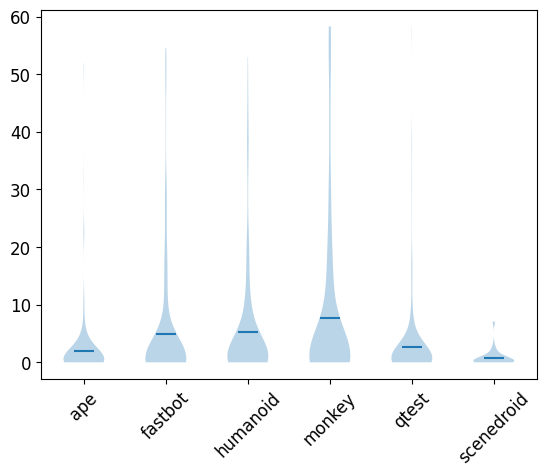

Statistical test
ape vs humanoid 3.5549187765634524e-05 -0.2079864436749429
ape vs monkey 4.822222652232868e-05 -0.20216606498194944
fastbot vs humanoid 0.0169395558656751 -0.12202348120715467
fastbot vs monkey 0.014789642902355096 -0.12320387614505261
fastbot vs scenedroid 0.024790001776087988 0.16925806114995304
humanoid vs ape 3.5549187765634524e-05 0.2079864436749429
humanoid vs fastbot 0.0169395558656751 0.12202348120715467
humanoid vs qtest 0.008955565829167487 0.13956187979779067
humanoid vs scenedroid 1.2971642027178454e-05 0.3309983452840596
monkey vs ape 4.822222652232868e-05 0.20216606498194944
monkey vs fastbot 0.014789642902355096 0.12320387614505261
monkey vs qtest 0.0060080781980237094 0.14522396114409067
monkey vs scenedroid 3.522910468233025e-05 0.3121886592474828
qtest vs humanoid 0.008955565829167487 -0.13956187979779067
qtest vs monkey 0.0060080781980237094 -0.14522396114409067
qtest vs scenedroid 0.005232286654838898 0.2149144557401438
scenedroid vs fastbot 0.02479

In [12]:
# tool_activity_time.pop("stoat")
violin_plot(tool_activity_time, "tool_activity_time.pdf", log_scale=False, show_prop=False)
statistic_test(tool_activity_time, [])
statistic_values(tool_activity_time)

Plotting violin plot


<Figure size 800x1000 with 0 Axes>

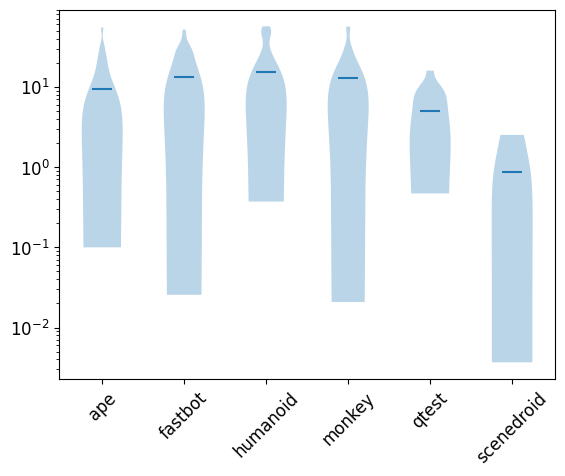

Statistical test
ape vs humanoid 0.03161874321828138 -0.2895408163265306
ape vs scenedroid 0.03537481928081454 0.7142857142857143
fastbot vs scenedroid 0.021364221364221364 0.7843137254901961
humanoid vs ape 0.03161874321828138 0.2895408163265306
humanoid vs qtest 0.0496827356768586 0.39880952380952384
humanoid vs scenedroid 0.007119021134593994 0.8809523809523809
monkey vs scenedroid 0.014855288995133612 0.8
qtest vs humanoid 0.0496827356768586 -0.39880952380952384
scenedroid vs ape 0.03537481928081454 -0.7142857142857143
scenedroid vs fastbot 0.021364221364221364 -0.7843137254901961
scenedroid vs humanoid 0.007119021134593994 -0.8809523809523809
scenedroid vs monkey 0.014855288995133612 -0.8
Statistical values
ape 9.30682619047619 3.9225416666666666 55.053666666666665 0.0999 12.295870459256314
fastbot 13.205349019607844 11.957208333333334 51.55915 0.025583333333333333 12.838153508068482
humanoid 15.363458928571427 6.669333333333333 56.80773333333333 0.3712666666666667 17.028561505197

In [13]:
# others_transition_time.pop("stoat")
violin_plot(others_transition_time, "others_transition_time.pdf", log_scale=True, show_prop=False)
statistic_test(others_transition_time, [])
statistic_values(others_transition_time)


Plotting violin plot


<Figure size 800x1000 with 0 Axes>

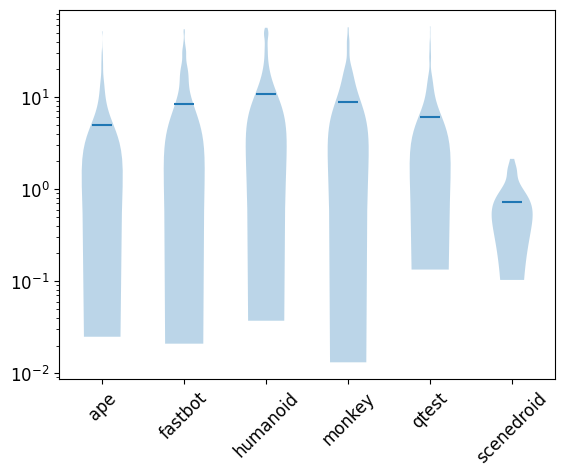

Statistical test
ape vs fastbot 0.004655838929153447 -0.12331257119313638
ape vs humanoid 1.7909805730090434e-08 -0.27351097178683387
ape vs monkey 5.8149689816684075e-05 -0.22144924503957875
ape vs qtest 0.04441524529605584 -0.0929601254750558
ape vs scenedroid 0.0003758059967365737 0.4252341597796143
fastbot vs ape 0.004655838929153447 0.12331257119313638
fastbot vs humanoid 0.006576200946864859 -0.13365861057740924
fastbot vs scenedroid 0.00019687301448457714 0.44609970674486804
humanoid vs ape 1.7909805730090434e-08 0.27351097178683387
humanoid vs fastbot 0.006576200946864859 0.13365861057740924
humanoid vs qtest 0.00010687816618359399 0.1997860558771709
humanoid vs scenedroid 1.881119957084539e-08 0.6848275862068965
monkey vs ape 5.8149689816684075e-05 0.22144924503957875
monkey vs qtest 0.010326142765615469 0.1481105054051557
monkey vs scenedroid 1.187433851332101e-06 0.6055696202531645
qtest vs ape 0.04441524529605584 0.0929601254750558
qtest vs humanoid 0.00010687816618359399 -

In [14]:
# real_transition_time.pop("stoat")
violin_plot(real_transition_time, "real_transition_time.png", log_scale=True, show_prop=False)
statistic_test(real_transition_time, [])
statistic_values(real_transition_time)

In [15]:
def pair_statistic_test(values1: list, values2: list):
    res = mannwhitneyu(values1, values2)
    pvalue = res.pvalue
    if pvalue > 0.05:
        return
    cliff = cliff_delta.cliff_delta(s1=values1, s2=values2, alpha=0.05, accurate_ci=True)
    delta = cliff[0]
    return pvalue, delta

In [16]:
for tool in real_transition_time.keys():
    transition_times = real_transition_time[tool]
    print(f"{tool} {np.mean(transition_times)} {np.median(transition_times)} {np.max(transition_times)} {np.min(transition_times)} {np.std(transition_times)}")

ape 4.920025573921029 2.007016666666667 51.87821666666667 0.0249 7.786920854104378
fastbot 8.344428690127078 3.1193833333333334 54.56975 0.020933333333333335 11.498846980069334
humanoid 10.690436637931032 4.349033333333333 56.56388333333334 0.03716666666666667 14.600812326624895
monkey 8.879652637130802 4.46505 57.24283333333334 0.013133333333333334 11.797347864151234
qtest 6.0429443430656935 2.1569083333333334 58.656933333333335 0.1336 9.828008202200882
scenedroid 0.725132 0.62885 2.1300166666666667 0.10315 0.5120120343837417


In [17]:
for tool in real_transition_time.keys():
    transition_times = real_transition_time[tool]
    print(f"{tool} {np.quantile(transition_times, 0.75)} {np.quantile(transition_times, 0.9)} {np.quantile(transition_times, 0.95)}")

ape 5.571641666666666 13.516720000000005 22.47486166666664
fastbot 12.588333333333333 26.334400000000002 32.85313333333333
humanoid 11.554904166666667 34.362260000000006 48.38650333333332
monkey 11.939391666666666 21.719288333333335 37.07175916666669
qtest 6.8252500000000005 15.339035 27.662480833333266
scenedroid 0.9539500000000001 1.5436800000000002 1.6542


In [18]:
all_transition_time = {}
for tool in real_transition_time.keys():
    try:
        all_transition_time[tool] = real_transition_time[tool] + others_transition_time[tool]
        pvalue, delta = pair_statistic_test(real_transition_time[tool], others_transition_time[tool])
        print(f"{tool} {pvalue} {delta}")
    except Exception as e:
        print(f"Error in {tool}")
        print(f"Error: {e}")


ape 0.0028948728275035775 -0.24724517906336088
fastbot 0.014166181188528314 -0.25513196480938416
humanoid 0.025697854802044992 -0.2583128078817734
monkey 0.023457215008322384 -0.2129113924050633
Error in qtest
Error: cannot unpack non-iterable NoneType object
Error in scenedroid
Error: cannot unpack non-iterable NoneType object


Plotting violin plot


<Figure size 800x1000 with 0 Axes>

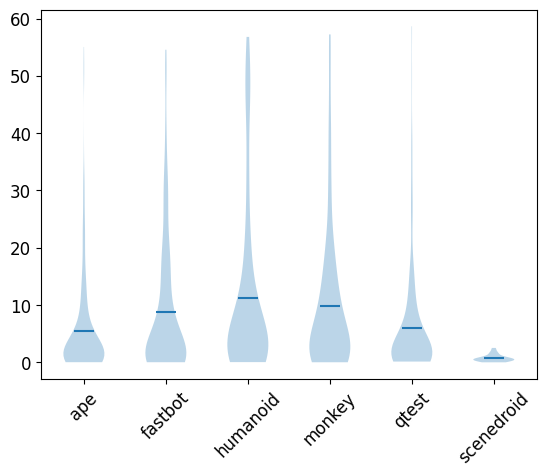

Statistical test
ape vs fastbot 0.003698563592518321 -0.11921718377088306
ape vs humanoid 3.5187107389854197e-09 -0.26937763906737655
ape vs monkey 1.0556294435435898e-06 -0.23922572058013586
ape vs scenedroid 3.174831094477231e-05 0.46948516876917834
fastbot vs ape 0.003698563592518321 0.11921718377088306
fastbot vs humanoid 0.005269127891633982 -0.13011282051282053
fastbot vs scenedroid 1.802447880199769e-05 0.4857142857142857
humanoid vs ape 3.5187107389854197e-09 0.26937763906737655
humanoid vs fastbot 0.005269127891633982 0.13011282051282053
humanoid vs qtest 4.387221529512523e-06 0.22740720817643895
humanoid vs scenedroid 5.441461314752574e-10 0.714010989010989
monkey vs ape 1.0556294435435898e-06 0.23922572058013586
monkey vs qtest 0.00016164907948222875 0.19869553523399677
monkey vs scenedroid 2.1344418723194034e-08 0.6524725274725275
qtest vs humanoid 4.387221529512523e-06 -0.22740720817643895
qtest vs monkey 0.00016164907948222875 -0.19869553523399677
qtest vs scenedroid 1.80

In [19]:
violin_plot(all_transition_time, "all_transition_time.pdf", log_scale=False, show_prop=False)
statistic_test(all_transition_time, [])
statistic_values(all_transition_time)

Plotting violin plot


<Figure size 800x1000 with 0 Axes>

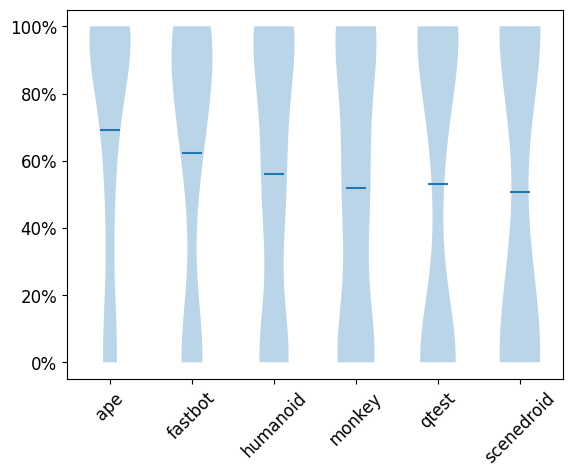

Statistical test
ape vs humanoid 0.04983919461031101 0.1711724948574787
ape vs monkey 0.009722860570433133 0.22627093740816925
humanoid vs ape 0.04983919461031101 -0.1711724948574787
monkey vs ape 0.009722860570433133 -0.22627093740816925
Statistical values
ape 0.6915970034913103 0.8785714285714286 1.0 0.0 0.37866018197641327
fastbot 0.6237707808917369 0.75 1.0 0.0 0.39621318645843256
humanoid 0.5613853911888155 0.6 1.0 0.0 0.40646804336783254
monkey 0.5174459743736852 0.5 1.0 0.0 0.4069341179940221
qtest 0.5312566920926612 0.6770833333333333 1.0 0.0 0.4593189309762302
scenedroid 0.5055555555555555 0.41666666666666663 1.0 0.0 0.4762572704477287


In [20]:
violin_plot(all_tool_proportion, "all_tool_proportion.pdf", log_scale=False, show_prop=True)
statistic_test(all_tool_proportion, [])
statistic_values(all_tool_proportion)

In [21]:
def calculate_precision_score(gt_transitions: list, tool_transitions: list):
    if len(gt_transitions) == 0:
        return 0
    if len(tool_transitions) == 0:
        return 0
    correct = 0
    for transition in tool_transitions:
        if transition in gt_transitions:
            correct += 1
    return correct / len(tool_transitions)

In [22]:
def calculate_recall_score(gt_transitions: list, tool_transitions: list):
    if len(gt_transitions) == 0:
        return 0
    if len(tool_transitions) == 0:
        return 0
    correct = 0
    for transition in tool_transitions:
        if transition in gt_transitions:
            correct += 1
    return correct / len(gt_transitions)

In [23]:
def calculate_f1_score(precision: float, recall: float):
    if precision == 0 or recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

In [24]:
def get_transitions_before_time(time: float, transition_time: list):
    transitions = []
    for transition, transition_time in transition_time:
        if transition_time <= time:
            transitions.append(transition)
    return transitions

In [25]:
def calculate_prf_score(gt_transitions: list, tool_transitions: list):
    precision = calculate_precision_score(gt_transitions, tool_transitions)
    recall = calculate_recall_score(gt_transitions, tool_transitions)
    f1 = calculate_f1_score(precision, recall)
    return precision, recall, f1

In [26]:
real_transitions_list = []
for apk in real_transitions.keys():
    transitions = real_transitions[apk]
    for transition in transitions:
        real_transitions_list.append(transition)

In [27]:
def get_prf_along_time():
    precisions = {}
    recalls = {}
    f1s = {}
    for tool in tools:
        precisions[tool] = []
        recalls[tool] = []
        f1s[tool] = []
    precisions["all"] = []
    recalls["all"] = []
    f1s["all"] = []
    for time in range(60):
        all_transitions = set()
        for tool in raw_transition_time.keys():
            if tool == "stoat":
                continue
            tool_transitions = get_transitions_before_time(time, raw_transition_time[tool])
            all_transitions.update(set(tool_transitions))
            precision, recall, f1 = calculate_prf_score(real_transitions_list, tool_transitions)
            precisions[tool].append(precision)
            recalls[tool].append(recall)
            f1s[tool].append(f1)
        all_transitions = list(all_transitions)
        precision, recall, f1 = calculate_prf_score(real_transitions_list, all_transitions)
        precisions["all"].append(precision)
        recalls["all"].append(recall)
        f1s["all"].append(f1)
    return precisions, recalls, f1s

precisions, recalls, f1s = get_prf_along_time()


In [28]:
print(precisions)

{'ape': [0, 0.9103448275862069, 0.900497512437811, 0.8938775510204081, 0.8978102189781022, 0.89, 0.8881789137380192, 0.8885448916408669, 0.8912386706948641, 0.8888888888888888, 0.8885714285714286, 0.8895184135977338, 0.8885793871866295, 0.8876712328767123, 0.8840970350404312, 0.883289124668435, 0.8839050131926122, 0.881578947368421, 0.8828125, 0.8808290155440415, 0.8791773778920309, 0.8791773778920309, 0.8797953964194374, 0.8762626262626263, 0.87468671679198, 0.8728179551122195, 0.8728179551122195, 0.8734491315136477, 0.8737623762376238, 0.8746928746928747, 0.8746928746928747, 0.8728606356968215, 0.8710462287104623, 0.8713592233009708, 0.8692493946731235, 0.8692493946731235, 0.8692493946731235, 0.8692493946731235, 0.8695652173913043, 0.8695652173913043, 0.8695652173913043, 0.8695652173913043, 0.8695652173913043, 0.8695652173913043, 0.8695652173913043, 0.8695652173913043, 0.8695652173913043, 0.8695652173913043, 0.8695652173913043, 0.8695652173913043, 0.8698795180722891, 0.86987951807228

In [29]:
print(recalls)

{'ape': [0, 0.15137614678899083, 0.20756880733944955, 0.2511467889908257, 0.28211009174311924, 0.30619266055045874, 0.31880733944954126, 0.3291284403669725, 0.338302752293578, 0.3486238532110092, 0.356651376146789, 0.36009174311926606, 0.3658256880733945, 0.37155963302752293, 0.3761467889908257, 0.38188073394495414, 0.3841743119266055, 0.3841743119266055, 0.38876146788990823, 0.38990825688073394, 0.3922018348623853, 0.3922018348623853, 0.3944954128440367, 0.39793577981651373, 0.40022935779816515, 0.4013761467889908, 0.4013761467889908, 0.4036697247706422, 0.4048165137614679, 0.40825688073394495, 0.40825688073394495, 0.40940366972477066, 0.4105504587155963, 0.411697247706422, 0.411697247706422, 0.411697247706422, 0.411697247706422, 0.411697247706422, 0.41284403669724773, 0.41284403669724773, 0.41284403669724773, 0.41284403669724773, 0.41284403669724773, 0.41284403669724773, 0.41284403669724773, 0.41284403669724773, 0.41284403669724773, 0.41284403669724773, 0.41284403669724773, 0.4128440

In [30]:
print(f1s)

{'ape': [0, 0.25958702064896755, 0.33737185461323393, 0.39212175470008953, 0.4293193717277487, 0.45563139931740615, 0.4691983122362869, 0.48033472803347277, 0.49044056525353286, 0.500823723228995, 0.5090016366612111, 0.5126530612244897, 0.5182778229082047, 0.5238480194017785, 0.5277554304102977, 0.5332265812650121, 0.5355715427657873, 0.5351437699680511, 0.5398089171974522, 0.5405405405405406, 0.5424266455194291, 0.5424266455194291, 0.5447347585114806, 0.5473186119873816, 0.5491738788355626, 0.5498821681068343, 0.5498821681068343, 0.552156862745098, 0.5532915360501567, 0.5566849100860046, 0.5566849100860046, 0.5573770491803279, 0.5580670303975058, 0.559190031152648, 0.5587548638132296, 0.5587548638132296, 0.5587548638132296, 0.5587548638132296, 0.5598755832037325, 0.5598755832037325, 0.5598755832037325, 0.5598755832037325, 0.5598755832037325, 0.5598755832037325, 0.5598755832037325, 0.5598755832037325, 0.5598755832037325, 0.5598755832037325, 0.5598755832037325, 0.5598755832037325, 0.560

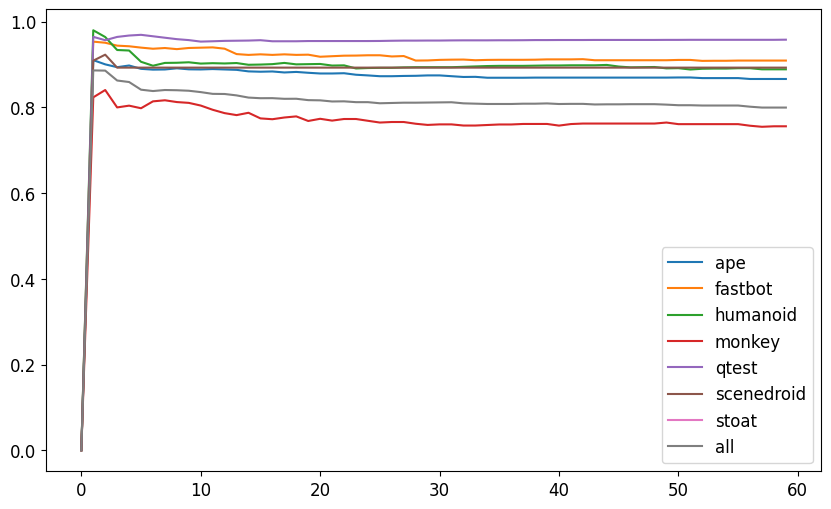

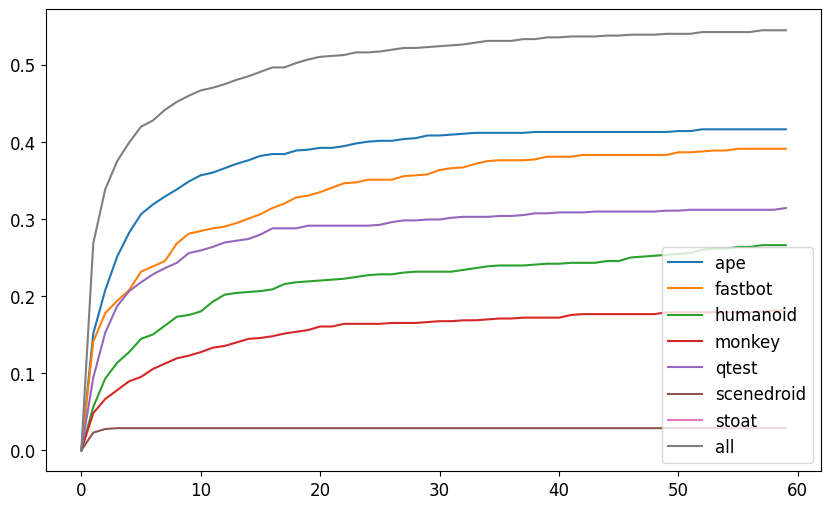

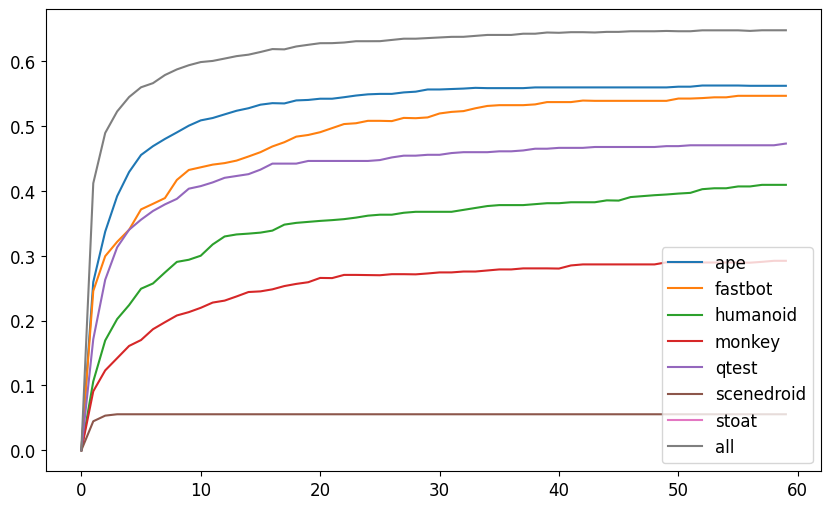

In [31]:
labels = [tool for tool in tools]
labels.append("all")

# plot the precision, recall, f1 along time
def plot_prf_along_time(result_dict: dict, file_name: str = None):
    plt.rcParams["font.size"] = 12
    plt.rcParams["font.family"] = "sans-serif"
    plt.figure(figsize=(10, 6))
    for tool in labels:
        plt.plot(result_dict[tool], label=f"{tool}")
    # plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    plt.legend(loc='lower right')
    plt.savefig(f"summary/figure/{file_name}", bbox_inches='tight')
    plt.show()

plot_prf_along_time(precisions, "precision_along_time.pdf")
plot_prf_along_time(recalls, "recall_along_time.pdf")
plot_prf_along_time(f1s, "f1_along_time.pdf")